In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import mlflow
from utils.mlflow import run_experiment
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from utils.eval import (
    plot_confusion_matrix,
    display_confusion_matrices,
    print_metrics,
    create_and_log_roc_curves,
    find_best_threshold
)
from utils.hyperparam import (
    hyperparameter_tuning,
    get_predictions_and_probabilities
)
import joblib

In [23]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns


In [24]:
train_inputs = joblib.load('data/train_inputs.pkl')
train_targets = joblib.load('data/train_targets.pkl')
val_inputs = joblib.load('data/val_inputs.pkl')
val_targets = joblib.load('data/val_targets.pkl')

In [25]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = train_inputs.select_dtypes(include=['object', 'category']).columns.tolist()

In [26]:
train_inputs[categorical_cols] = train_inputs[categorical_cols].astype('category')
val_inputs[categorical_cols] = val_inputs[categorical_cols].astype('category')

In [27]:
preprocessor = ColumnTransformer(
    [("scaler", StandardScaler(), numeric_cols)]
)

#### Random Search hyperparameter optimisation. 

In [28]:
best_model, best_params = hyperparameter_tuning(
    train_inputs, val_inputs,
    train_targets, val_targets,
    preprocessor,
    framework="random_search",      
    n_iterations=40
)

In [29]:
metrics, *_ = run_experiment(
    best_model,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="XGB_Best_RandomSearch",
    registered_model_name="XGB_Best"
)

Registered model 'XGB_Best' already exists. Creating a new version of this model...
Created version '15' of model 'XGB_Best'.


In [30]:
train_pred, val_pred, train_proba, val_proba = get_predictions_and_probabilities(
    best_model, train_inputs, val_inputs
)

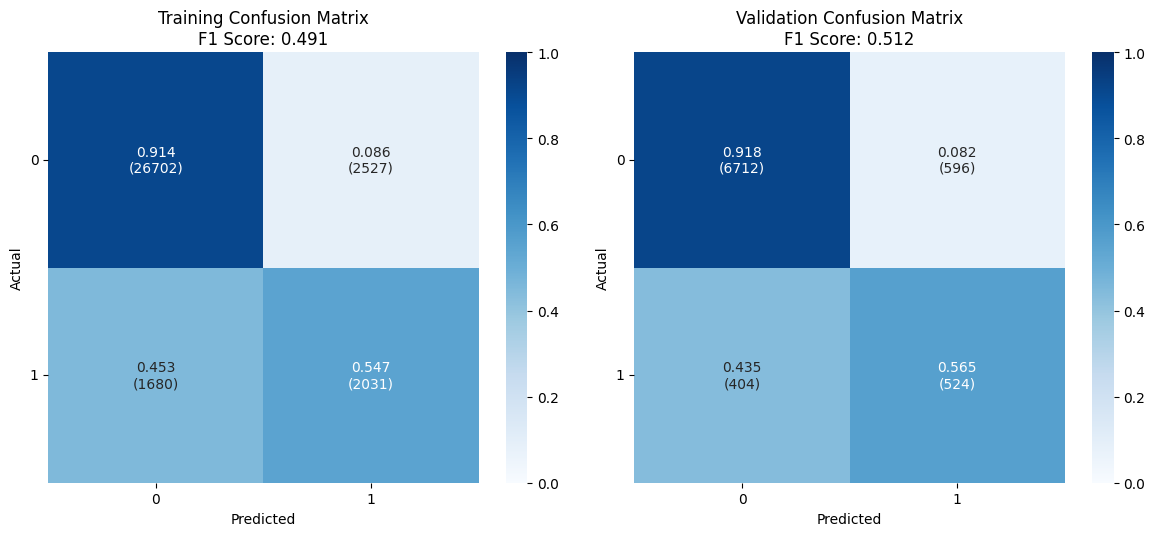

In [31]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"
)

In [32]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.491           0.512
Precision         0.446           0.468
Recall            0.547           0.565
Accuracy          0.872           0.879
ROC AUC           0.802           0.808


In [33]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.4
Best F1 score: 0.5209387942936033


#### Optuna hyperparameter optimisation. 

In [34]:
best_model, best_params = hyperparameter_tuning(
    train_inputs, val_inputs,
    train_targets, val_targets,
    preprocessor,
    framework="optuna",    
    n_iterations=40
)

In [35]:
metrics, *_ = run_experiment(
    best_model,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="XGB_Best_Optuna",
    registered_model_name="XGB_Best"
)

Registered model 'XGB_Best' already exists. Creating a new version of this model...
Created version '16' of model 'XGB_Best'.


In [36]:
train_pred, val_pred, train_proba, val_proba = get_predictions_and_probabilities(
    best_model, train_inputs, val_inputs
)

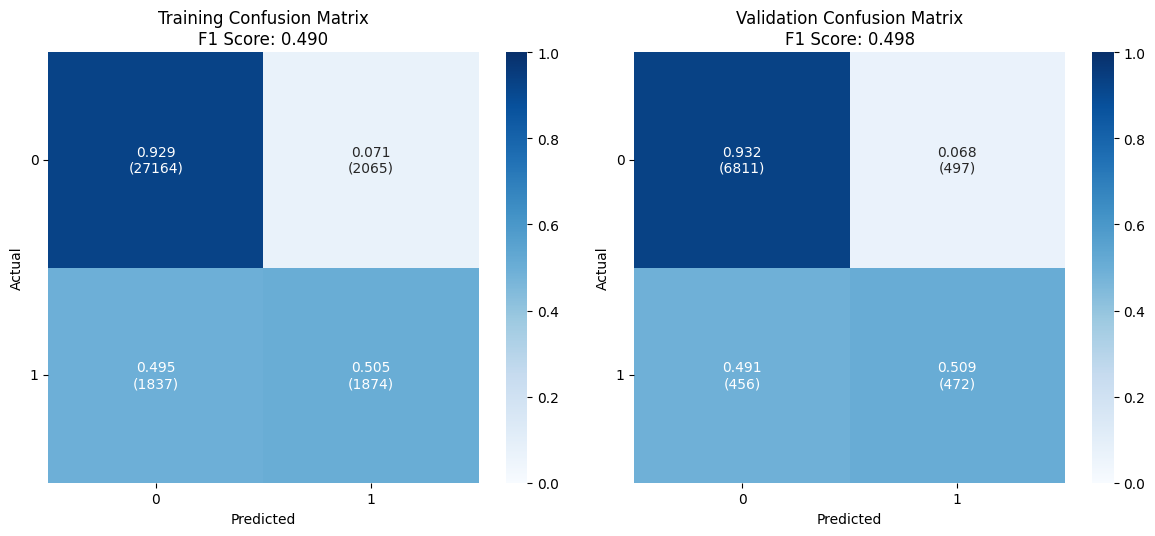

In [37]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"
)

In [38]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.490           0.498
Precision         0.476           0.487
Recall            0.505           0.509
Accuracy          0.882           0.884
ROC AUC           0.806           0.810


In [39]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.4
Best F1 score: 0.5233644859813084


#### Hyperopt hyperparameter optimisation. 

In [40]:
best_model, best_params = hyperparameter_tuning(
    train_inputs, val_inputs,
    train_targets, val_targets,
    preprocessor,
    framework="hyperopt",     
    n_iterations=40
)

100%|██████████| 40/40 [00:13<00:00,  2.88trial/s, best loss: -0.8093228311439518]


In [41]:
metrics, *_ = run_experiment(
    best_model,
    train_inputs, train_targets,
    val_inputs,   val_targets,
    run_name="XGB_Best_Hyperopt",
    registered_model_name="XGB_Best"
)

Registered model 'XGB_Best' already exists. Creating a new version of this model...
Created version '17' of model 'XGB_Best'.


In [42]:
train_pred, val_pred, train_proba, val_proba = get_predictions_and_probabilities(
    best_model, train_inputs, val_inputs
)

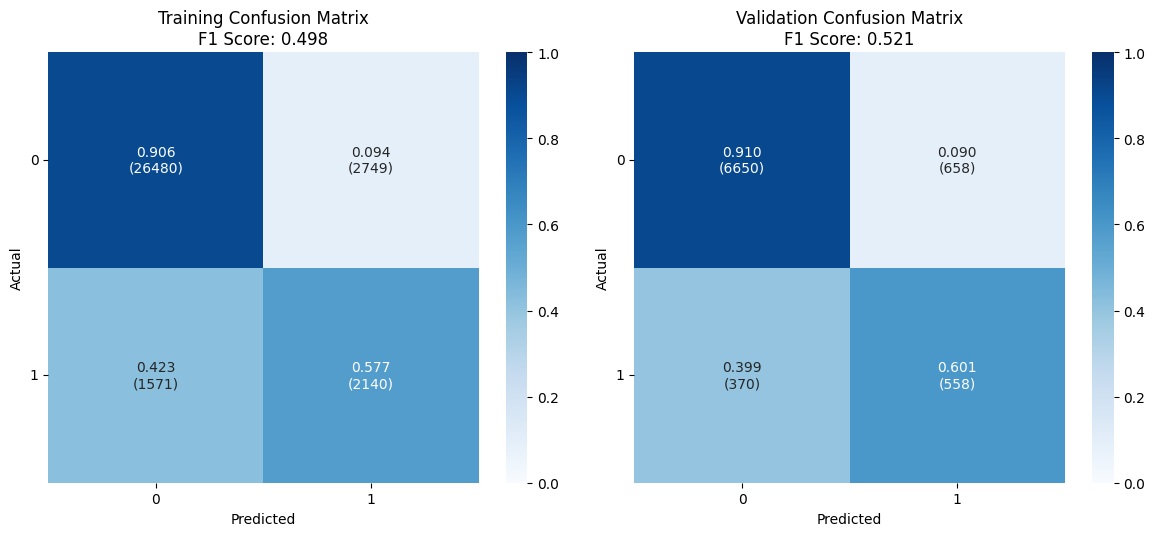

In [43]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"
)

In [44]:
print_metrics(train_targets, train_pred, val_targets, val_pred, train_proba, val_proba)

Train vs Validation

Metric            Train      Validation
----------------------------------------
F1 Score          0.498           0.521
Precision         0.438           0.459
Recall            0.577           0.601
Accuracy          0.869           0.875
ROC AUC           0.806           0.809


In [45]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.53
Best F1 score: 0.5209923664122137


#### Let's have a look at the comparison of metrics in MLFlow.

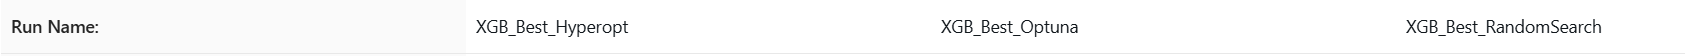

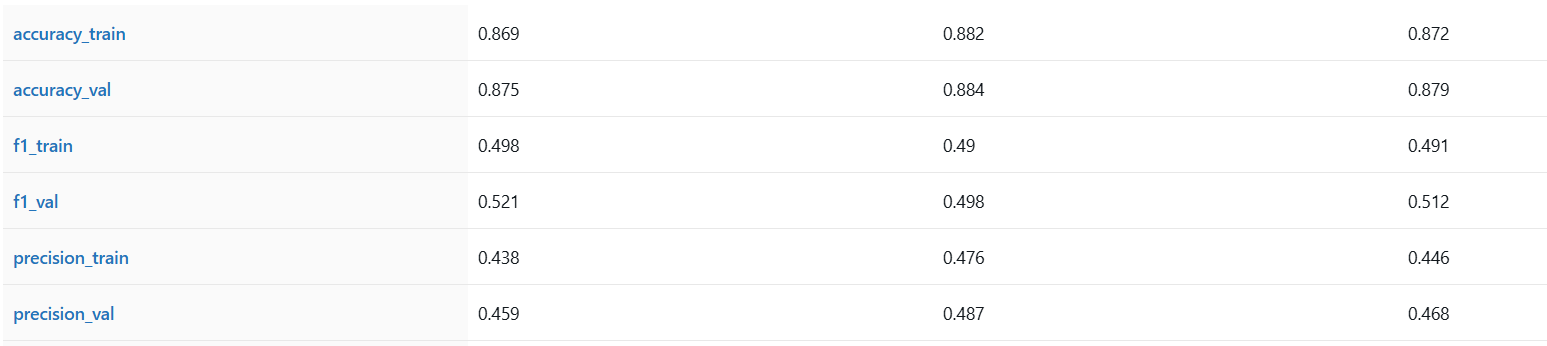

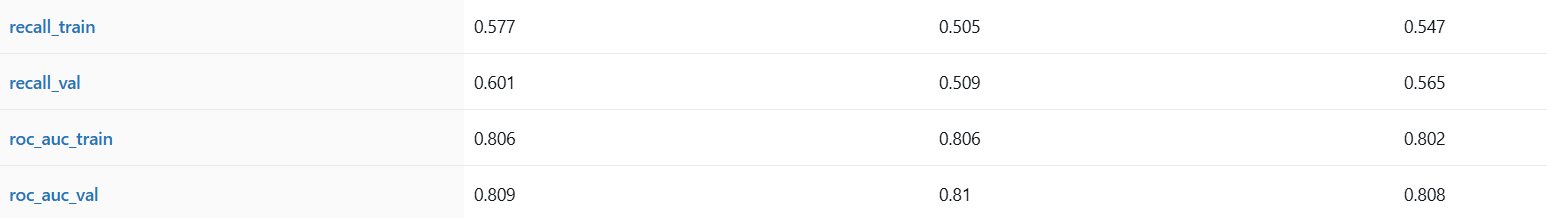

As shown in the MLflow summary table, Hyperopt consistently achieved the highest F1 score. In earlier experiments, Optuna and Random Search yielded mixed results—each occasionally outperforming the other. However, Hyperopt repeatedly delivered the best performance across runs.